##**Finding similar items in pyspark**##

My name is Hamed Davoodi, matriculation number 11267A. I utilized a PySpark DataFrame to analyze document similarity through MinHash and Locality-Sensitive Hashing. The following steps outline the process I implemented in this notebook:

1. **Environment Setup**: Installed required packages and configured environment.

2. **Data Retrieval**: Used Kaggle API key to download the dataset.

3. **Initialize Spark Session**: Configured and started the Spark session.

4. **Load Dataset**: Loaded the dataset into a distributed format.

5. **Adjust Partitioning**: Repartitioned the dataset to enable the scalability.

6. **Filter and Preprocess**: Excluded non-English language items and cleaned the text data.

7. **Tokenize Data**: Splited the documents into tokens.

8. **Generate N-Grams**: Created N-Gram sequences from tokens.

9. **Zero-One Features**: Applied one-hot-encoding to convert N-Grams into feature vectors.

10. **MinHash Application**: Reduced feature vector dimensions using MinHash.

11. **Band Creation**: Segmented MinHash signatures into bands.

12. **Bucketing**: Used python default hashing function to hash the bands into buckets to find the candidate pairs.

13. **Similarity Check**: Calculated Jaccard similarity to confirm document similarity.

1- First, I set up the pyspark environment and configuaration based on the colab suggestions.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
# Alternatively we can simply run:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=a649cc638e77c094727dad51baacb8322d0cc6790c0ce6f3ae28191849d58a1f
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

2- Setup os environment with kaggle credentials

In [ ]:
# setup kaggle api
import os
os.environ['KAGGLE_USERNAME'] = "hameddavoodi"
os.environ['KAGGLE_KEY'] = "01daed4fc18680ab2abc7488c3723bb2"

In [ ]:
# Download kaggle dataset
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
 99% 1.87G/1.88G [00:23<00:00, 126MB/s]
100% 1.88G/1.88G [00:23<00:00, 86.4MB/s]


In [ ]:
# Unzip dataset
!unzip 1-3m-linkedin-jobs-and-skills-2024.zip

Archive:  1-3m-linkedin-jobs-and-skills-2024.zip
  inflating: job_skills.csv          
  inflating: job_summary.csv         
  inflating: linkedin_job_postings.csv  


Also I installed the autotime for ipython in order to measure the executaion time.

In [ ]:
!pip install ipython-autotime -q

In [ ]:
# timer for cell execution
%load_ext autotime

time: 453 µs (started: 2024-09-12 20:19:19 +00:00)


In [ ]:
#import findspark
#findspark.init()
from pyspark.sql import SparkSession

# Create a Spark session with dynamic allocation and AQE enabled, also I added some extra configuration to optimze the performance
spark = SparkSession.builder.appName("AMD_hameddavoodi")\
    .config("spark.executor.memory", "4g")\
    .config("spark.executor.cores", "2")\
    .config("spark.executor.instances", "4")\
    .config("spark.driver.memory", "4g")\
    .master("local[*]")\
    .getOrCreate()

# Display session info to verify
spark

time: 18.6 s (started: 2024-09-12 20:24:28 +00:00)


In [ ]:
# check the configuration
spark.sparkContext.getConf().getAll()

[('spark.app.startTime', '1726172680516'),
 ('spark.executor.instances', '4'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.app.id', 'local

time: 52.3 ms (started: 2024-09-12 20:24:46 +00:00)


NOTE: I tried parquet format and found that the load time was significantly faster compared to CSV!

In [ ]:
# Load the CSV file
spark_df = spark.read.options(header=True, multiLine=True, delimiter=",", quote='"', escape='"')\
                     .csv("/content/job_summary.csv")\
                     .limit(50).persist()
                     # for faster computation during the exam I simply chose 50 elements instead of over one million.

time: 7.18 s (started: 2024-09-12 20:24:46 +00:00)


We may still encounter skewness when data is distributed across nodes. To prevent this issue, I used repartitioning and sorting within partitions. Note that to properly repartition, I needed to convert the DataFrame to an RDD.
In addition, we limited 50 rows, so with 5 partition we will have 10 row per partition.

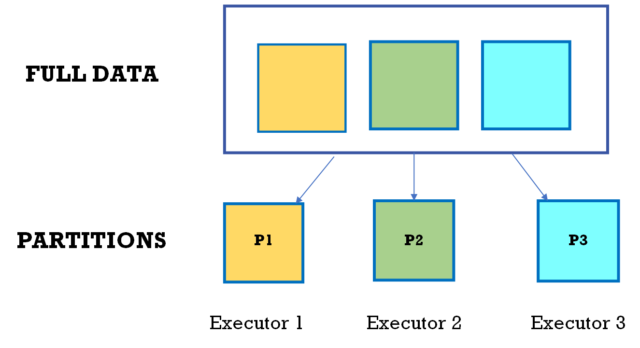

In [ ]:
spark_df.show()

+--------------------+--------------------+
|            job_link|         job_summary|
+--------------------+--------------------+
|https://www.linke...|Rock N Roll Sushi...|
|https://www.linke...|Schedule\n: PRN i...|
|https://www.linke...|Description\nIntr...|
|https://uk.linked...|Commercial accoun...|
|https://www.linke...|Address:\nUSA-CT-...|
|https://www.linke...|Description\nOur\...|
|https://www.linke...|Company Descripti...|
|https://uk.linked...|An exciting oppor...|
|https://www.linke...|Job Details:\nJob...|
|https://www.linke...|Our\nRestaurant T...|
|https://www.linke...|Our General Manag...|
|https://www.linke...|Earning potential...|
|https://www.linke...|Dollar General Co...|
|https://au.linked...|Restaurant Descri...|
|https://au.linked...|Who We Are\nWe ar...|
|https://www.linke...|A Place Where Peo...|
|https://www.linke...|Description\nThe ...|
|https://www.linke...|Overview\nDescrip...|
|https://www.linke...|Description\nThe ...|
|https://www.linke...|Laboratory

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id
# Add a unique key column to the DataFrame
df_with_key = spark_df.withColumn("key", monotonically_increasing_id())
# Here we change the dataframe to RDD
mapped_df = df_with_key.select('key', 'job_summary').rdd

time: 861 ms (started: 2024-09-12 20:25:04 +00:00)


In [ ]:
# Repartition
mapped_rdd = mapped_df.repartition(50)

time: 105 ms (started: 2024-09-12 20:25:04 +00:00)


In [ ]:
from pyspark.sql import Row
import re

# Function to filter out rows containing unrecognized characters (Chinese, Arabic, etc.)
def filter_unrecognized_characters(row):
    """
    Filter out rows containing unrecognized (non-ASCII) characters such as Chinese or Arabic.
    """
    job_summary = row[1]
    if not re.search(r"[\u4e00-\u9fff\u0600-\u06FF\u0750-\u077F]", job_summary):
        return True
    return False

# Function to clean the job summary by removing punctuations and converting to lowercase
def clean_job_summary(row):
    """
    Clean the job summary by removing non-alphabet characters and converting to lowercase.
    """
    key, job_summary = row
    cleaned_summary = re.sub(r"[^a-zA-Z\s\n]", "", job_summary)
    cleaned_summary = re.sub(r"\n", " ", job_summary)
    cleaned_summary = cleaned_summary.lower()  # Convert to lowercase
    return (key, cleaned_summary)

# Assume rdd is your initial RDD with (key, job_summary) format
# Step 1: Filter out rows with unrecognized characters
recognized_rdd = mapped_rdd.filter(filter_unrecognized_characters)

# Step 2: Clean the job summary (remove punctuation, convert to lowercase)
cleaned_rdd = recognized_rdd.map(clean_job_summary)


time: 11.2 ms (started: 2024-09-12 20:25:05 +00:00)


In [ ]:
cleaned_rdd.persist()

PythonRDD[26] at RDD at PythonRDD.scala:53

time: 51.2 ms (started: 2024-09-12 20:25:05 +00:00)


In [ ]:
cleaned_rdd.getNumPartitions()

50

time: 209 ms (started: 2024-09-12 20:25:05 +00:00)


In [ ]:
cleaned_rdd.take(1)

[(0,
  'rock n roll sushi is hiring a restaurant manager! as our restaurant manager, you’ll never be bored. you’ll be responsible for making sure our restaurant runs smoothly. we offer competitive compensation insurance benefits bonus opportunities a great work atmosphere duties/responsibilities ensuring that our restaurant is fully and appropriately staffed at all times maintaining operational excellence so our restaurant is running efficiently and effectively ensuring that all laws, regulations, and guidelines are being followed creating a restaurant atmosphere that both patrons and employees enjoy various other tasks as needed requirements previous experience as a restaurant manager extensive food and beverage knowledge, and the ability to remember and recall ingredients and dishes to inform customers and wait staff great leadership skills familiarity with restaurant management software demonstrated ability to coordinate a staff show more show less')]

time: 37.9 s (started: 2024-09-12 20:25:05 +00:00)


LSH mechanism builds a hash table consisting of several parts which puts a pair of signatures into the same bucket if they have at least one corresponding part.

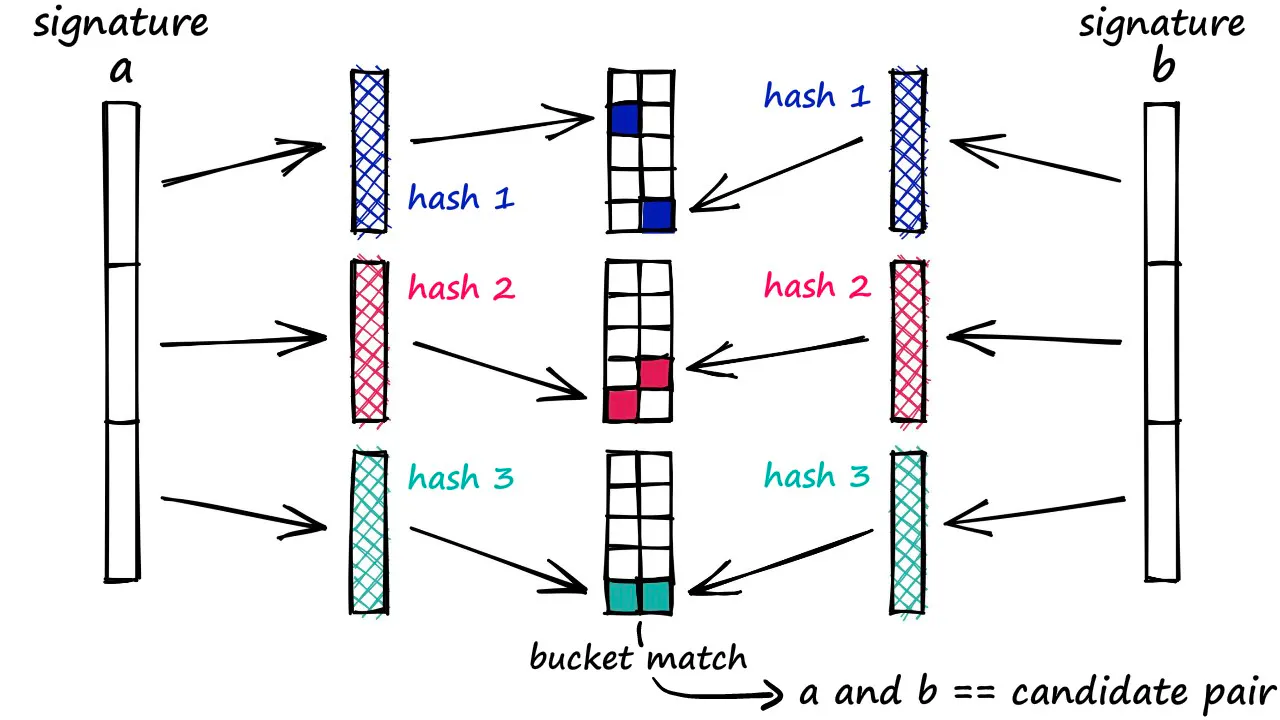

Note that the idea of lsh is to hash each bands, part of signiture matrix, in a way that each band uses its own hashfunction, so the idea is to reduce again the number of elements in each band.

In [ ]:
import random

# FUNCTION 1: Shingle generation (small overlapping substrings)
def generate_shingles(text, k=2):
    """
    Generate shingles from text.
    Args:
        text: The input string (document).
        k: The length of each shingle.
    Returns:
        A set of shingles.
    """
    shingles = {text[i:i+k] for i in range(len(text) - k + 1)}
    return shingles

# FUNCTION 2: Get unique shingles from all documents (this is the framework to implement onehotencoding)
def get_unique_shingles(rdd, k=2):
    """
    Collect all unique shingles from the RDD of documents.
    Args:
        rdd: RDD of (index, document) tuples.
        k: The length of each shingle.
    Returns:
        A sorted list of unique shingles across all documents.
    """
    unique_shingles = rdd.flatMap(lambda doc: generate_shingles(doc[1], k)).distinct().collect()
    return sorted(unique_shingles)

# Function 3: One-hot encode the document
def one_hot_encode_document(doc, unique_shingles, k=2):
    """
    One-hot encode a single document based on unique shingles.
    Args:
        doc: The document (string).
        unique_shingles: A sorted list of unique shingles across all documents.
        k: The length of each shingle.
    Returns:
        A binary vector where each index corresponds to the presence of a shingle.
    """
    shingles = generate_shingles(doc, k)

    one_hot_vector = [0] * len(unique_shingles)

    for shingle in shingles:
        if shingle in unique_shingles:
            index = unique_shingles.index(shingle)
            one_hot_vector[index] = 1
    return one_hot_vector

# FUNCTION 4: Generate multiple hash functions (framework to generate MinHash signiture)
def generate_hash_functions(num_functions, max_hash_value):
    """
    Generate multiple hash functions by using random parameters.
    Args:
        num_functions: Number of hash functions to generate.
        max_hash_value: The maximum hash value (e.g., 10^6).
    Returns:
        A list of hash functions.
    """
    hash_functions = []
    for i in range(num_functions):
        a = random.randint(1, max_hash_value)
        b = random.randint(0, max_hash_value)
        def hash_func(x, a=a, b=b):
            return (a * (x) + b) % max_hash_value
        hash_functions.append(hash_func)
    return hash_functions

# FUNCTION 5: Apply MinHash
def minhash_signature(one_hot_vector, hash_functions):
    """
    Compute MinHash signature for a one-hot encoded vector.
    Args:
        one_hot_vector: A binary vector (one-hot encoded).
        hash_functions: A list of hash functions.
    Returns:
        A list representing the MinHash signature.
    """
    signature = []
    for h in hash_functions:
        min_hash = min(h(i) for i, value in enumerate(one_hot_vector) if value == 1)
        signature.append(min_hash)
    return signature

# FUNCTION 6: Hash each band into buckets (LSH)
def hash_band(band):
    """
    Hash a band (a subset of a signature) to create a bucket ID.
    """
    return hash(tuple(band)) % 10**6 # Since the python default hash function uses murmur hashing, i would like to refine the range of the hash limited to 1 million

# FUNCTION 7: Perform LSH on the RDD
def lsh_rdd(document_rdd, num_bands):
    """
    Perform locality-sensitive hashing (LSH) in a distributed manner using PySpark.

    Args:
        document_rdd: An RDD of (document_id, signature) pairs.
        num_bands: The number of bands to divide the signature into.

    Returns:
        An RDD of (bucket_id, document_id) pairs.
    """
    def hash_bands_for_document(doc):
        doc_id, signature = doc
        band_size = len(signature) // num_bands
        buckets = {}
        for i in range(num_bands):
            band = signature[i * band_size:(i + 1) * band_size]
            bucket_id = hash_band(band)
            buckets[bucket_id] = doc_id
        return [(bucket_id, doc_id) for bucket_id in buckets.keys()]

    # Hash each document's signature into buckets
    bucketed_docs_rdd = document_rdd.flatMap(hash_bands_for_document)
    return bucketed_docs_rdd

# FUNCTION 8: Group by bucket
def group_by_bucket(bucketed_docs_rdd):
    """
    Group documents by their bucket IDs in a distributed manner using reduceByKey.

    Args:
        bucketed_docs_rdd: An RDD of (bucket_id, document_id) pairs.

    Returns:
        An RDD of (bucket_id, list_of_document_ids) pairs.
    """
    grouped_docs_rdd = bucketed_docs_rdd.map(lambda x: (x[0], [x[1]])) \
                                        .reduceByKey(lambda doc_list1, doc_list2: doc_list1 + doc_list2)
    return grouped_docs_rdd

time: 4.43 ms (started: 2024-09-12 20:25:43 +00:00)


Now it is time to map the functions we built before on our RDDs. note that, I used 100 hash functions, 2 word shingles, and 25 bands. and finally I groupby hashes, to get id of document in each buckets.

In [ ]:
k = 2  # Shingle length
unique_shingles = get_unique_shingles(cleaned_rdd, k)

# One-hot encode each document in the RDD
one_hot_encoded_rdd = cleaned_rdd.map(lambda doc: (doc[0], one_hot_encode_document(doc[1], unique_shingles, k)))

# Generate hash functions
num_hash_functions = 100
max_hash_value = 10**3
hash_functions = generate_hash_functions(num_hash_functions, max_hash_value)

# Compute MinHash signatures for each document
minhash_rdd = one_hot_encoded_rdd.map(lambda doc: (doc[0], minhash_signature(doc[1], hash_functions)))


time: 37.3 s (started: 2024-09-12 20:25:43 +00:00)


In [ ]:
one_hot_encoded_rdd.take(1)

In [ ]:
minhash_rdd.take(1)

[(0,
  [14,
   2,
   6,
   14,
   6,
   3,
   1,
   0,
   21,
   8,
   2,
   5,
   19,
   3,
   1,
   0,
   9,
   3,
   0,
   12,
   1,
   7,
   7,
   5,
   1,
   0,
   3,
   2,
   5,
   9,
   2,
   32,
   4,
   1,
   19,
   2,
   0,
   0,
   0,
   8,
   1,
   13,
   7,
   8,
   7,
   17,
   1,
   7,
   2,
   1,
   1,
   4,
   21,
   9,
   6,
   3,
   0,
   2,
   1,
   3,
   0,
   3,
   5,
   3,
   1,
   1,
   0,
   5,
   5,
   3,
   4,
   0,
   0,
   7,
   4,
   35,
   160,
   0,
   10,
   1,
   5,
   0,
   2,
   1,
   0,
   7,
   1,
   0,
   1,
   9,
   1,
   1,
   8,
   1,
   1,
   1,
   0,
   0,
   10,
   3])]

time: 40.8 s (started: 2024-09-12 20:32:55 +00:00)


In [ ]:

# Apply LSH
num_bands = 25
bucketed_docs_rdd = lsh_rdd(minhash_rdd, num_bands)

# Group by bucket IDs
grouped_docs_rdd = group_by_bucket(bucketed_docs_rdd)

# Filter buckets with more than one document
filtered_grouped_docs_rdd = grouped_docs_rdd.filter(lambda x: len(x[1]) > 1)

# Collect and display the filtered results
filtered_grouped_docs = filtered_grouped_docs_rdd.take(20)

for bucket_id, doc_ids in filtered_grouped_docs:
    print(f"Bucket {bucket_id}: Documents {doc_ids}")

Bucket 291200: Documents [1, 4, 5, 9, 10, 11, 12, 15, 16, 17, 19, 21, 22, 23, 26, 27, 28, 33, 39, 41, 42, 46, 47, 48, 49]
Bucket 724851: Documents [2, 40]
Bucket 959101: Documents [15, 17, 18, 24, 25, 35, 40, 45]
Bucket 208701: Documents [24, 34, 44]
Bucket 473552: Documents [1, 7, 16, 17, 23, 37, 45]
Bucket 298152: Documents [3, 16, 17, 25, 32, 37, 38]
Bucket 679252: Documents [8, 29, 37]
Bucket 346852: Documents [8, 25]
Bucket 559052: Documents [14, 17]
Bucket 592252: Documents [15, 21]
Bucket 795702: Documents [15, 23, 27, 48]
Bucket 751652: Documents [29, 32]
Bucket 72202: Documents [32, 37]
Bucket 301753: Documents [26, 33]
Bucket 364053: Documents [30, 40]
Bucket 704804: Documents [0, 29]
Bucket 332004: Documents [2, 38]
Bucket 514905: Documents [10, 31]
Bucket 839956: Documents [2, 3, 20, 24, 31, 34, 36, 38, 40, 43, 44, 45]
Bucket 195707: Documents [5, 9, 19, 41, 46]
time: 50.4 s (started: 2024-09-12 10:49:33 +00:00)


We can also use similar model to store the results in a Dictionary for the look up process faster.

Now Lets pick up a pair to check their similarity.

In [ ]:
def jaccard_similarity(shingles1, shingles2):
    """
    Calculate the Jaccard similarity between two sets of shingles.
    Args:
        shingles1: The set of shingles from document 1.
        shingles2: The set of shingles from document 2.
    Returns:
        The Jaccard similarity
    """
    intersection = len(shingles1.intersection(shingles2))
    union = len(shingles1.union(shingles2))
    jaccard_similarity = intersection / union if union != 0 else 0
    return jaccard_similarity


doc1 = cleaned_rdd.filter(lambda doc: doc[0] == 0).collect()[0][1]
doc2 = cleaned_rdd.filter(lambda doc: doc[0] == 28).collect()[0][1]

# Generate MinHash signatures for both documents
signature1 = generate_shingles(doc1)
signature2 = generate_shingles(doc2)


similarity = jaccard_similarity(signature1, signature2)
print(f"Approximate Jaccard Similarity from MinHash between doc1 and doc2: {similarity}")

Approximate Jaccard Similarity from MinHash between doc1 and doc2: 0.5847750865051903
time: 36.2 s (started: 2024-09-12 08:47:22 +00:00)


In [ ]:
print(f"Document 1 ##############################:\n{doc1}\n")
print(f"Document 2 ##############################:\n{doc2}\n")

Document 1 ##############################:
rock n roll sushi is hiring a restaurant manager! as our restaurant manager, you’ll never be bored. you’ll be responsible for making sure our restaurant runs smoothly. we offer competitive compensation insurance benefits bonus opportunities a great work atmosphere duties/responsibilities ensuring that our restaurant is fully and appropriately staffed at all times maintaining operational excellence so our restaurant is running efficiently and effectively ensuring that all laws, regulations, and guidelines are being followed creating a restaurant atmosphere that both patrons and employees enjoy various other tasks as needed requirements previous experience as a restaurant manager extensive food and beverage knowledge, and the ability to remember and recall ingredients and dishes to inform customers and wait staff great leadership skills familiarity with restaurant management software demonstrated ability to coordinate a staff show more show less

For the False positive and False negative we use the probibility formula to check the probability of getting correct answers based on our setup.

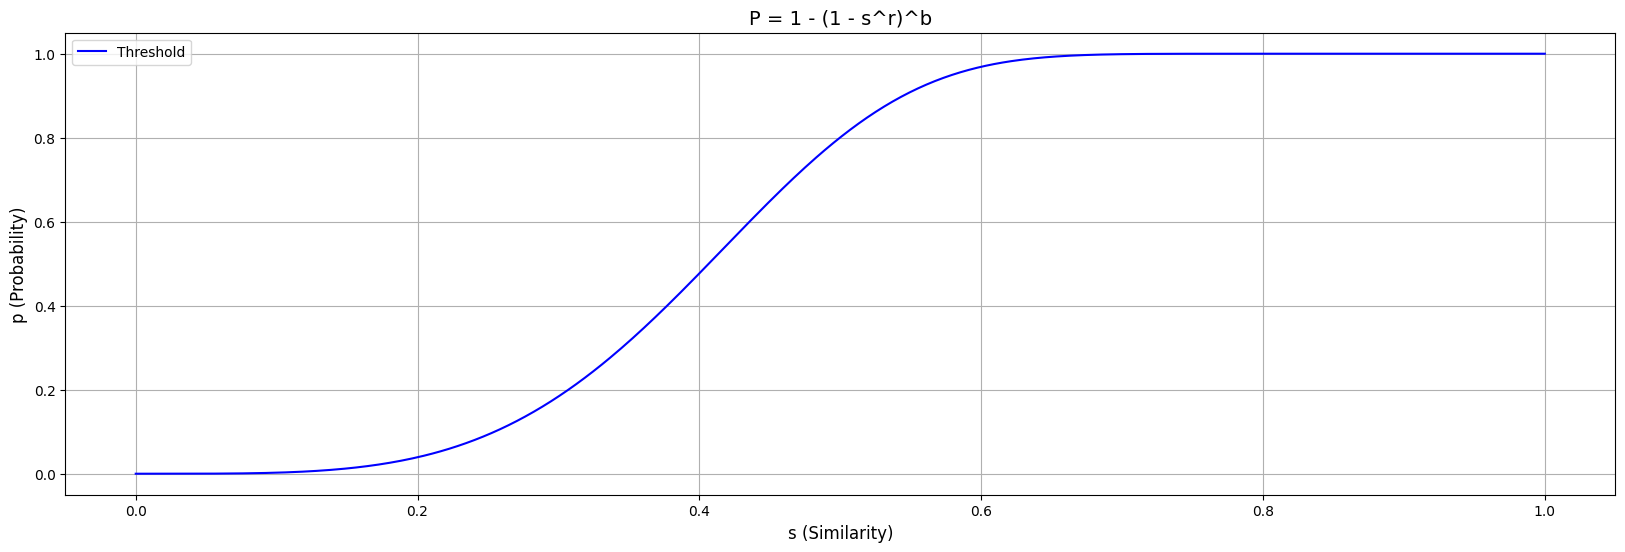

time: 1.12 s (started: 2024-09-12 08:35:13 +00:00)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
s = np.linspace(0, 1, 500)
r = 4  #number of rows
b = 25  #number of bands

# Probability formula
p = 1 - (1 - s**r)**b

plt.figure(figsize=(20, 6))
plt.plot(s, p, label="Threshold", color='b')
plt.title('P = 1 - (1 - s^r)^b', fontsize=14)
plt.xlabel('s (Similarity)', fontsize=12)
plt.ylabel('p (Probability)', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
k = 2  # Shingle length
unique_shingles = get_unique_shingles(cleaned_rdd, k)

# One-hot encode each document in the RDD
one_hot_encoded_rdd = cleaned_rdd.map(lambda doc: (doc[0], one_hot_encode_document(doc[1], unique_shingles, k)))

# Generate hash functions
num_hash_functions = 100
max_hash_value = 10**3
hash_functions = generate_hash_functions(num_hash_functions, max_hash_value)

# Compute MinHash signatures for each document
minhash_rdd = one_hot_encoded_rdd.map(lambda doc: (doc[0], minhash_signature(doc[1], hash_functions)))

# Apply LSH
num_bands = 5
bucketed_docs_rdd = lsh_rdd(minhash_rdd, num_bands)

# Group by bucket IDs
grouped_docs_rdd = group_by_bucket(bucketed_docs_rdd)

# Filter buckets with more than one document
filtered_grouped_docs_rdd = grouped_docs_rdd.filter(lambda x: len(x[1]) > 1)

# Collect and display the filtered results
filtered_grouped_docs = filtered_grouped_docs_rdd.take(20)

for bucket_id, doc_ids in filtered_grouped_docs:
    print(f"Bucket {bucket_id}: Documents {doc_ids}")

Bucket 834702: Documents [13, 30]
Bucket 845806: Documents [1, 12, 22, 47, 49]
Bucket 795617: Documents [31, 38]
Bucket 372223: Documents [5, 39, 41]
Bucket 596825: Documents [42, 48]
Bucket 752827: Documents [17, 42]
Bucket 608330: Documents [5, 39, 41, 46]
Bucket 801139: Documents [9, 39, 41]
Bucket 822241: Documents [35, 48]
Bucket 249450: Documents [12, 22, 47]
Bucket 903052: Documents [4, 15, 21, 25]
Bucket 902456: Documents [2, 15]
Bucket 919356: Documents [12, 22, 47]
Bucket 902159: Documents [5, 39, 41, 46]
Bucket 853068: Documents [21, 30]
Bucket 900771: Documents [19, 34]
Bucket 663373: Documents [5, 13, 46]
Bucket 974278: Documents [19, 27]
Bucket 267980: Documents [12, 22, 47]
Bucket 272681: Documents [12, 22, 36, 47]
time: 1min 27s (started: 2024-09-12 08:50:29 +00:00)


In [ ]:
def jaccard_similarity(shingles1, shingles2):
    """
    Calculate the Jaccard similarity between two sets of shingles.
    Args:
        shingles1: The set of shingles from document 1.
        shingles2: The set of shingles from document 2.
    Returns:
        The Jaccard similarity
    """
    intersection = len(shingles1.intersection(shingles2))
    union = len(shingles1.union(shingles2))
    jaccard_similarity = intersection / union if union != 0 else 0
    return jaccard_similarity


doc1 = cleaned_rdd.filter(lambda doc: doc[0] == 12).collect()[0][1]
doc2 = cleaned_rdd.filter(lambda doc: doc[0] == 22).collect()[0][1]

# Generate MinHash signatures for both documents
signature1 = generate_shingles(doc1)
signature2 = generate_shingles(doc2)


similarity = jaccard_similarity(signature1, signature2)
print(f"Approximate Jaccard Similarity from MinHash between doc1 and doc2: {similarity}")
print(f"Document 1 ##############################:\n{doc1}\n")
print(f"Document 2 ##############################:\n{doc2}\n")

Approximate Jaccard Similarity from MinHash between doc1 and doc2: 1.0
Document 1 ##############################:
dollar general corporation has been delivering value to shoppers for more than 80 years. dollar general helps shoppers save time. save money. every day.® by offering products that are frequently used and replenished, such as food, snacks, health and beauty aids, cleaning supplies, basic apparel, housewares and seasonal items at everyday low prices in convenient neighborhood locations. dollar general operates more than 18,000 stores in 47 states, and we’re still growing. learn more about dollar general at www.dollargeneral.com. general summary the store manager candidate supports the store manager in the effective implementation of all store processes including employee supervision, staffing, inventory management, stocking and receiving, paperwork, and store needs. this position is utilized to foster interactive development of an external candidate for the store manager role

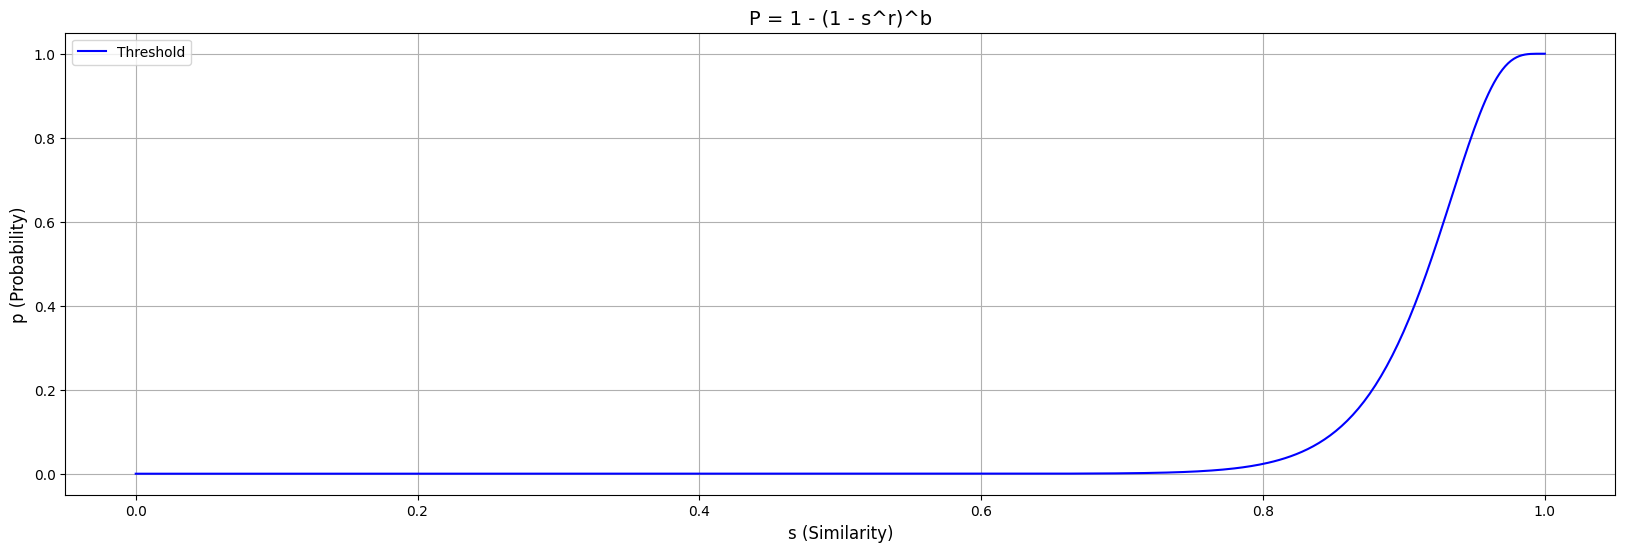

time: 1.23 s (started: 2024-09-12 08:49:23 +00:00)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
s = np.linspace(0, 1, 500)
r = 24  #number of rows
b = 5  #number of bands

# Probability formula
p = 1 - (1 - s**r)**b

plt.figure(figsize=(20, 6))
plt.plot(s, p, label="Threshold", color='b')
plt.title('P = 1 - (1 - s^r)^b', fontsize=14)
plt.xlabel('s (Similarity)', fontsize=12)
plt.ylabel('p (Probability)', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
from collections import defaultdict
from itertools import combinations

# Initialize a dictionary
doc_pair_count = defaultdict(int)

# Iterate through the filtered_grouped_docs and count document pairs in each bucket
for bucket_id, doc_ids in filtered_grouped_docs:
    for doc_pair in combinations(sorted(doc_ids), 2):
        doc_pair_count[doc_pair] += 1

# Filter out document pairs that appear in more than x buckets
common_doc_pairs = {pair: count for pair, count in doc_pair_count.items() if count > 4}

for pair, count in common_doc_pairs.items():
    print(f"Document pair {pair} appears in {count} buckets")


Document pair (12, 22) appears in 5 buckets
Document pair (12, 47) appears in 5 buckets
Document pair (22, 47) appears in 5 buckets
time: 4.16 ms (started: 2024-09-12 08:58:16 +00:00)
